<h3><strong>Tweede opzet CNN</strong></h3><br>
Ik was niet helemaal tevreden met het eerste model en wilde graag ook meer code schrijven, i.p.v. copy/pasten.<br>
Ben op zoek gegaan naar een voorbeeld en vond onderstaande. Het inladen en opdelen (train/validation) van de data, het labelen etc. gebeurt op een net andere manier als in het Tensorflow-tutorial,<br>
prettig om zo voor de toekomst hiervoor meer mogelijkheden ter beschikking te hebben.<br>
Tevens werd er door tussentijds print-statements goed inzichtelijk gemaakt wat er precies gebeurt (meeste hiervan zijn ge-outcomment)<br>
Aan de hand van een YouTube-tutorial heb ik de onderstaande code meegeschreven, later nog zaken als bv. Confusion Matrix toegevoegd. 

Tutorial: https://www.youtube.com/watch?v=bns5ELvbzVk&t=86s + https://www.youtube.com/watch?v=ZN6P_GEJ7lk&t=1375s

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import datetime

import random

# Onderstaande heb ik op een later tijdstip toegevoegd om te kijken of dit a. werkte en b. meerwaarde kon hebben.
# https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks
%load_ext tensorboard

Onderstaande blok is later toegevoegd om steeds vanuit dezelfde beginsituatie te kunnen vertrekken.

In [2]:
# The below is necessary for starting:
# Numpy / 
# core Python /  
# TensorFlow backend generated random numbers
# in a well-defined initial state.

np.random.seed(123)

random.seed(123)

tf.random.set_seed(1234)

# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed

In [3]:
# Can be used to clear any Tensorboard logs from previous runs
# rm -rf ./data/logs/

De variabelen zijn met hier met hoofdletters geschreven omdat ze "constanten" zijn.<br>

<strong>Assigning and Declaring Python Constants</strong><br>
The first and foremost thing to remember while declaring Python Constants is that the constant values should always be declared in capital letters/uppercase.<br>
The values declared should not be abbreviations of the names, and it has to be declared completely.<br>
https://www.educba.com/python-constants/

In [4]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 15

Inladen van de data (images)

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../augmented_data/Train",
    seed = 123,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

# hier wordt de augmented_data set van 4000 (1000 per label) afb. ingeladen

Found 4000 files belonging to 4 classes.


Ophalen van labels

In [6]:
class_names = dataset.class_names
class_names

['Blotch_Apple', 'Normal_Apple', 'Rot_Apple', 'Scab_Apple']

In [7]:
# len(dataset)
# length is aantal batches van 32 (32 x 125 = 4000)

Inladen van testset

In [8]:
testset = tf.keras.preprocessing.image_dataset_from_directory(
    "../augmented_data/Test",
    seed = 123,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 120 files belonging to 4 classes.


In [9]:
class_names = testset.class_names
class_names

['Blotch_Apple', 'Normal_Apple', 'Rot_Apple', 'Scab_Apple']

In [10]:
# len(testset)

Voor een visuele inspectie van de afbeeldingen en bijbehorende labels in de data-set

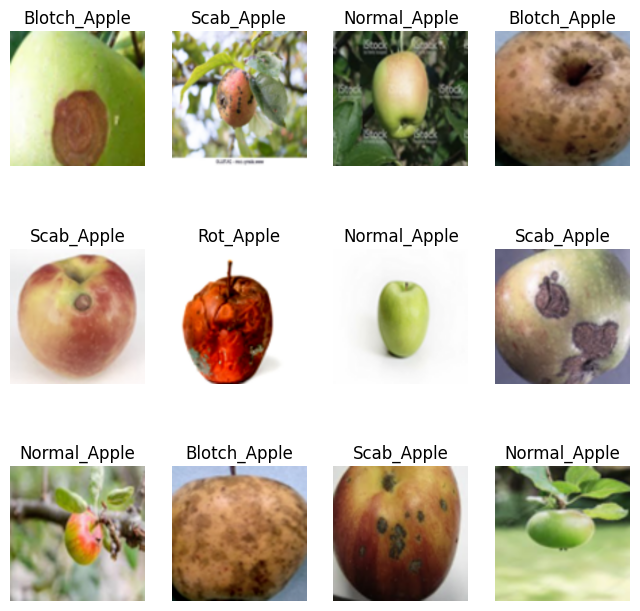

In [11]:
plt.figure(figsize=(8, 8)) # om dimensies totale afbeelding aan te passen en tekst leesbaar te houden
for image_batch, label_batch in dataset.take(1): # toont at random afbeeldingen uit de dataset
    # print(image_batch.shape)    # batch shape is 32 afb. à 224x224 pixels in RGB
    # print(label_batch.numpy())  # labels van de batch
    # print(image_batch[0].numpy) # numpy array
    # print(image_batch[0].shape) # dimensies van afb. 224x224 pixels in RGB
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)    
        # plt.imshow(image_batch[0].numpy().astype("uint8"))
        # plt.title(class_names[label_batch[0]])
        plt.imshow(image_batch[i].numpy().astype("uint8")) # met [i] wordt de loop doorlopen en 12 afb. getoond, met vaste waarde bv. [0] wordt één afb. 12x getoond
        plt.title(class_names[label_batch[i]])
        plt.axis("off") # om extra informatie (> assen) uit te zetten

Zo ook voor de testdata

In [12]:
# plt.figure(figsize=(10, 10)) # om dimensies totale afbeelding aan te passen en tekst leesbaar te houden
# for image_batch, label_batch in testset.take(1): # toont at random afbeeldingen uit de dataset
#     for i in range(12):
#         ax = plt.subplot(3, 4, i+1)    
#         plt.imshow(image_batch[i].numpy().astype("uint8")) 
#         plt.title(class_names[label_batch[i]])
#         plt.axis("off") 

Berekenen hoe de dataset in train- en validation-dataset, en evt. test-dataset opgedeeld kan worden.

In [13]:
# 80% van de dataset voor training
# train_size = 0.8
# len(dataset)*train_size # (in batches)

In [14]:
# train_ds = dataset.take(100) # met .take() worden de eerste (x) batches geslecteerd
# len(train_ds)

In [15]:
# test_ds = dataset.skip() # met .skip() worden er overgeslagen, maar ...
# omdat we een aparte folder voor de test-dataset hebben, kunnen we deze als onderstaand inladen
# test_ds = testset
# len(test_ds) # lengte in batches

In [16]:
# 20% van de dataset voor validation
# val_size = 0.2
# len(dataset)*val_size

In [17]:
# val_ds = dataset.skip(100)
# len(val_ds)

# eerste 100 batches voor training, deze slaan we over (.skip) en nemen de laatste 25 voor validation

Wat bovenstaand berekend is, kunnen we ook als onderstaande functie opschrijven:

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.2, shuffle=True, shuffle_size=10000): # test_split niet, want extra folder met test-afbeeldingen


    assert (train_split + val_split) == 1 
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12) # seed for predictability, same result 
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    # test_ds = ds.skip(train_size).skip(val_size) # als we de test-dataset ook uit dezelfde batch/folder zouden halen
    test_ds = testset
        
    return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
# len(train_ds)

In [21]:
# len(val_ds)

In [22]:
# len(test_ds)

In [23]:
# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) # bij CPU én GPU gebruik om afb. te cachen en zo sneller data in te laden.
# val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<h3><strong>Preprocessing pipeline</strong></h3><br>
<strong>Resize en rescale</strong> om de afbeeldingen allemaal dezelfde afmetingen te geven en de waarden tussen 0 en 1 te zetten.

In [24]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)    
])

<strong>Data augementation</strong> om de afbeeldingen te modificeren:<br>
<ul>
    <li> 
horizontaal en verticaal flippen
</li> 
<li>
willekeurige rotatie
</li> 
<li>
zoom
</li> 
</ul>

In [25]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    # layers.experimental.preprocessing.RandomZoom(0.3)
])

Apply data augmentation to train dataset

In [26]:
# train_ds = train_ds.map(
#     lambda x, y: (data_augmentation(x, training=True), y)
# ).prefetch(buffer_size=tf.data.AUTOTUNE)

Batch normalization om het model sneller en stabieler te maken. Bij Batch normalization wordt 

In [27]:
tf.keras.layers.BatchNormalization(
    axis=-1,
    momentum=0.99,
    epsilon=0.001,
    center=True,
    scale=True,
    beta_initializer='zeros',
    gamma_initializer='ones',
    moving_mean_initializer='zeros',
    moving_variance_initializer='ones',
    beta_regularizer=None,
    gamma_regularizer=None,
    beta_constraint=None,
    gamma_constraint=None,
)

# minus **kwargs

In [28]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),  
    layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),   
    # layers.Dropout(0.2), 
    layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),   
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')          
])

model.build(input_shape=input_shape)

Callback voor early stopping. In de praktijk is deze functie bijna niet gebruikt, weinig voorgekomen dat er eerder gestopt moet worden.

In [29]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

Overzicht van de topologie van het model.

In [30]:
# model.summary()

Tensorboard logs

In [31]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [32]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),   # laatste layer in model gebruikt softmax als activatie
    metrics=['accuracy']
)

In [33]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
    callbacks = [tensorboard_callback]
)

Epoch 1/15
100/100 [==============================] - 24s 166ms/step - loss: 0.9234 - accuracy: 0.6572 - val_loss: 1.7570 - val_accuracy: 0.3388
Epoch 2/15
100/100 [==============================] - 18s 159ms/step - loss: 0.6221 - accuracy: 0.7588 - val_loss: 3.2916 - val_accuracy: 0.2512
Epoch 3/15
100/100 [==============================] - 18s 166ms/step - loss: 0.5060 - accuracy: 0.8069 - val_loss: 2.1556 - val_accuracy: 0.3500
Epoch 4/15
100/100 [==============================] - 24s 212ms/step - loss: 0.4225 - accuracy: 0.8353 - val_loss: 1.1045 - val_accuracy: 0.6313
Epoch 5/15
100/100 [==============================] - 22s 187ms/step - loss: 0.3518 - accuracy: 0.8669 - val_loss: 0.5278 - val_accuracy: 0.7962
Epoch 6/15
100/100 [==============================] - 22s 192ms/step - loss: 0.3072 - accuracy: 0.8797 - val_loss: 0.7018 - val_accuracy: 0.7675
Epoch 7/15
100/100 [==============================] - 22s 195ms/step - loss: 0.2517 - accuracy: 0.9094 - val_loss: 0.1909 - val_ac

In [34]:
scores = model.evaluate(test_ds)

4/4 [==============================] - 1s 192ms/step - loss: 2.1795 - accuracy: 0.5833


In [35]:
# scores

In [36]:
# history

In [37]:
# history.params

In [38]:
# history.history.keys()

In [39]:
# len(history.history['accuracy'])

In [40]:
# type(history.history['loss'])
# len(history.history['loss'])

In [41]:
# history.history['loss'][:5]# show loss for first 5 epochs

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

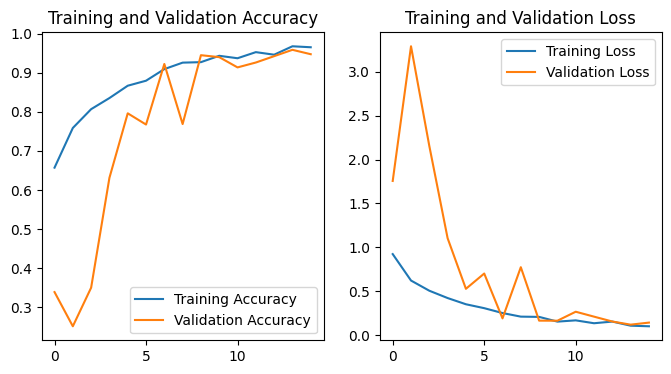

In [43]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

First image to predict
First image's actual label: Blotch_Apple
Predicted label: Scab_Apple


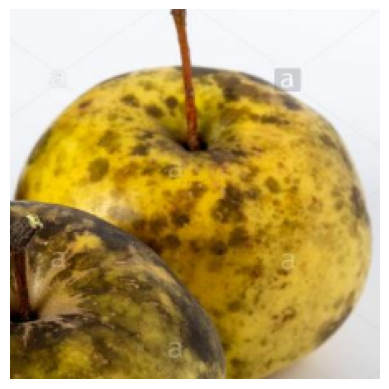

In [44]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    plt.axis("off")
    print("First image's actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted label:", class_names[np.argmax(batch_prediction[0])])
    # print(batch_prediction[0]) # input for np.argmax() above
    

Met de predict functie kunnen we het <i>eigenlijke</i> en <i>voorspelde</i> label in een overzicht van afbeeldingen tonen en<br>
aangeven met welke <i>zekerheid</i> de uitspraak gedaan kan worden.<br>

Met <i>shuffle = True</i> bij het inladen van de testdata wordt er slechts vanuit één label afbeeldingen ingeladen.

In [45]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images_batch[i])
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
       
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence
                                  

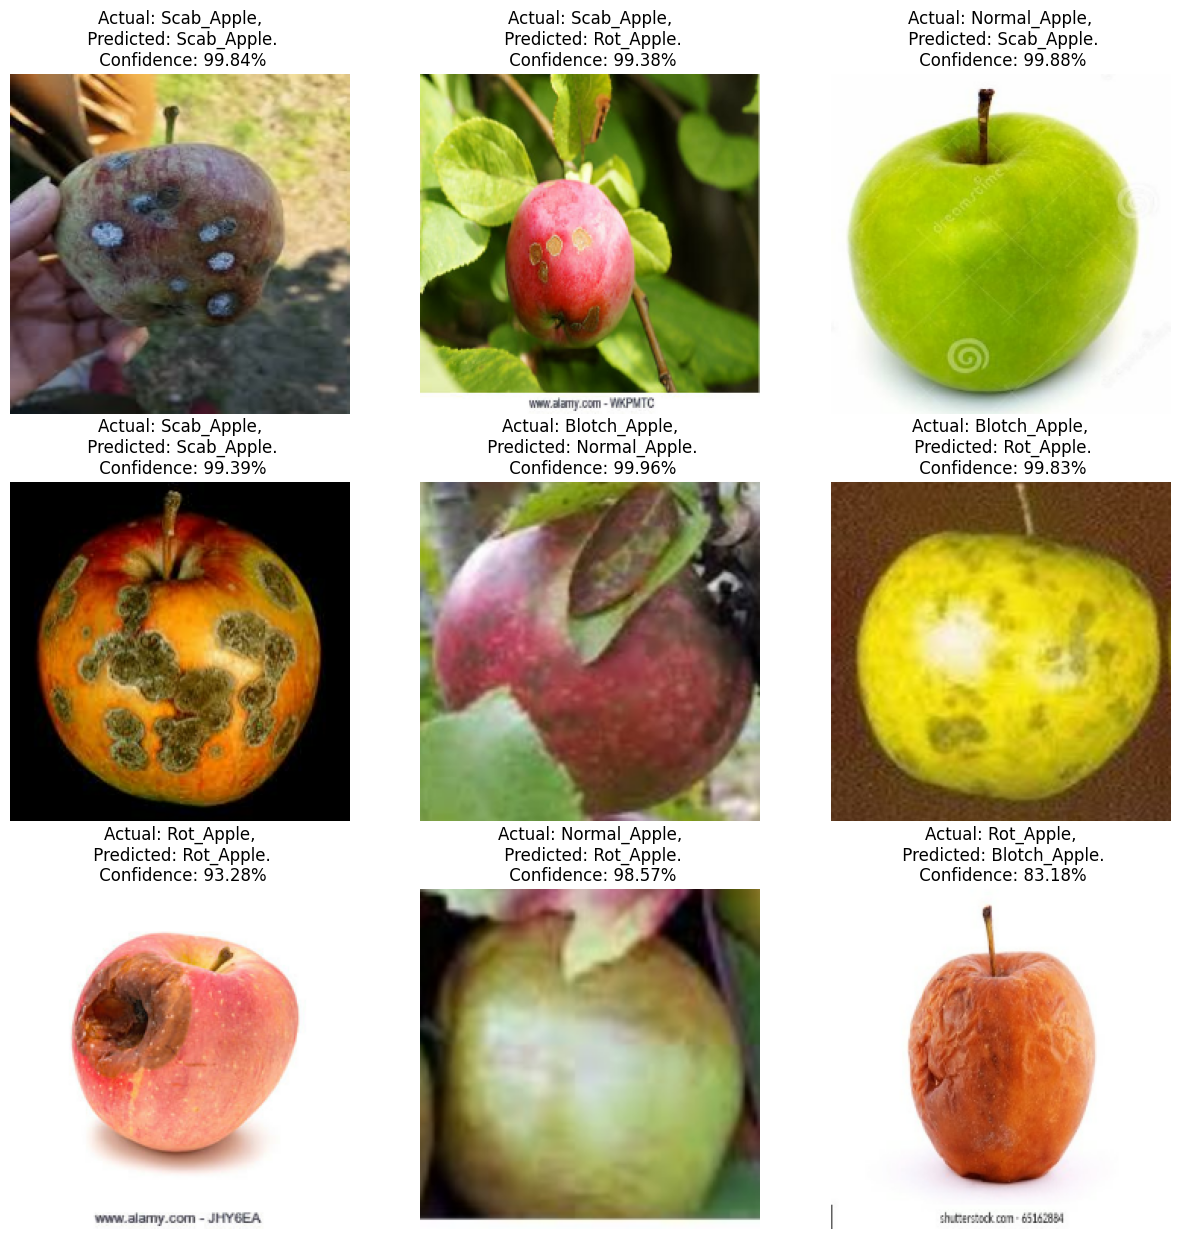

In [46]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy()) 
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

Met onderstaande code wordt er voor elke run een nieuwe (genummerde) folder aangemaakt waarin het model opgeslagen wordt.

In [47]:
import os

model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}") # check ValueError: invalid literal for int() with base 10: '.gitkeep' <<<

INFO:tensorflow:Assets written to: ../models/8\assets


Model opslaan kan ook als onderstaand, maar de .h5-variant is deprecated:<br>

There are two formats you can use to save an entire model to disk: the <strong>TensorFlow SavedModel </strong>format, and the older Keras H5 format. The recommended format is SavedModel. It is the default when you use model.save(). > https://www.tensorflow.org/guide/keras/ save_and_serialize <. Hence the method above is preferred.

In [48]:
# model.save("..models/../apples.h5")

In [49]:
model.predict(test_ds)

array([[2.93031597e-04, 3.36208859e-06, 1.26541802e-03, 9.98438179e-01],
       [8.00462663e-01, 2.84143332e-02, 1.53493822e-01, 1.76291000e-02],
       [2.51489419e-05, 8.45115380e-07, 1.15538192e-07, 9.99973893e-01],
       [1.98285133e-01, 4.28086816e-04, 7.79846489e-01, 2.14402732e-02],
       [1.68465044e-06, 4.47807097e-10, 9.94590640e-01, 5.40769100e-03],
       [1.12775508e-02, 1.92037551e-04, 2.67519783e-02, 9.61778522e-01],
       [1.49737243e-04, 9.41911161e-01, 4.02096435e-02, 1.77293811e-02],
       [1.67937862e-04, 7.02692802e-08, 9.93777633e-01, 6.05444703e-03],
       [7.40374863e-01, 1.27489211e-05, 6.09663688e-02, 1.98646039e-01],
       [1.75650585e-02, 1.83132715e-06, 9.48940217e-01, 3.34928036e-02],
       [3.20156596e-06, 9.99948740e-01, 1.33260613e-07, 4.78520742e-05],
       [1.66234828e-03, 2.34191716e-02, 9.90749104e-04, 9.73927855e-01],
       [3.17624581e-05, 5.56835005e-08, 9.64873552e-01, 3.50945406e-02],
       [1.26910772e-05, 3.52956151e-04, 4.99234557e

Deze confusion matrix met standaard test_ds geeft onbetrouwbare resultaten, vandaar dat ik hier onder een nieuwe versie geïmplementeerd heb.

In [50]:
# predictionBatch = model.predict(test_ds)
# predictionEnhanced = tf.argmax(predictionBatch, axis=-1)
# actualCategories = tf.concat([y for x, y in test_ds], axis=0)

# confusionMatrix = metrics.confusion_matrix(actualCategories, predictionEnhanced)

# cmDisplay = metrics.ConfusionMatrixDisplay(confusion_matrix = confusionMatrix, display_labels = ["Blotch_Apple", "Normal_Apple", "Rot_Apple", "Scab_Apple"])

# cmDisplay.plot()

# plt.show()

Bij onderstaande Confusion Matrix laden we de test dataset in met <i>shuffle=False</i>.<br>
Dit zorgt er enerzijds voor dat de matrix bij opnieuw runnen (zonder het gehele model opnieuw te trainen) steeds dezelfde waarden toont,<br>
daarnaast zijn het aantal goed voorspelde labels (True == Predicted) juist weer, komt overeen met percentage uit test validation.

In [1]:
test_ds = tf.keras.utils.image_dataset_from_directory(
      "../augmented_data/Test",
      shuffle=False,
      image_size=(IMAGE_SIZE, IMAGE_SIZE),
      batch_size = BATCH_SIZE 
      )

test_label = test_ds.class_names

print(test_label)


batchPredictions = model.predict(test_ds)

predicted_categories = tf.argmax(batchPredictions, axis=1)

true_categories = tf.concat([y for x, y in test_ds], axis=0)

result_confusion_matrix = confusion_matrix(true_categories, predicted_categories)

cm_display = ConfusionMatrixDisplay(confusion_matrix = result_confusion_matrix, display_labels = ["Blotch_Apple", "Normal_Apple", "Rot_Apple", "Scab_Apple"])

cm_display.plot()
plt.show()

NameError: name 'tf' is not defined

Tensorboard werkt en logt resultaten. Heb dit, voor nu, verder niet uitgediept of gebruikt om de resultaten te analyseren.

In [52]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 16904), started 6 days, 4:05:33 ago. (Use '!kill 16904' to kill it.)